modernNLP project
Team rfl

# Training the final Model

## 1. Setup

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Root path

import os
ROOT_PATH = "/content/drive/MyDrive/projet_NLP/final"
print(os.listdir(ROOT_PATH))

import sys
sys.path.append(ROOT_PATH)

['data', 'reward_model', 'evaluate_reward_model.py', 'final_model', '__pycache__', 'reward_model.py', 'training_reward_model.ipynb', 'training_final_model.ipynb']


In [3]:
# Installations
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.0 MB/s eta 0:00:00

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Imports

import json
import re
import math
from tqdm import tqdm
import random
from collections import defaultdict, Counter
from itertools import combinations, compress
import pickle

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from datasets import Dataset, load_dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig, AutoModelForSequenceClassification
from reward_model import CustomRewardModelConfig, CustomRewardModel
from evaluate import load

import matplotlib.pyplot as plt

In [ ]:
# Set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

## 2. Collect data

### 2.1. Data from the CS-552 class

In [ ]:
# Open solutions file
with open(ROOT_PATH+'/data/solutions_v1.json', encoding="utf8") as json_file:
    solutions = json.load(json_file)

# Look at the data
solutions[0:2]

[{'answer': 'Threshold flux for cones, $\\phi_{r}=90 \\times 220=19800$ photons $/ \\mathrm{s}$\n\n\\begin{equation}\n\\text { Total energy for threshold, } E_{\\text {total }}=\\frac{\\#_{-} \\text {of } \\_ \\text {photons } \\times h \\times c}{\\lambda}=19800 \\times 3.58 \\times 10^{-19} \\mathrm{~J}=7.08 \\times 10^{-15} \\mathrm{~J}\n\\end{equation}\n\nThreshold for the optic power, $P=\\frac{E_{\\text {total }}}{t}=7.08 \\times 10^{-15} \\mathrm{~W}$\n\nThreshold for the intensity, $I_{\\text{th}}=\\frac{\\text{optic\\_power}}{\\text{area}}=\\frac{7.08 \\times 10^{-15} \\mathrm{~W}}{10^{-8} \\mathrm{~m}^{2}}$',
  'question': 'Rods (peak response at $\\lambda=507 \\mathrm{~nm}$ ) and cones (peak response at $555 \\mathrm{~nm}$ ) are the photosensitive cells in human eye. Although\n\nrods are more sensitive, they cannot register colors (unlike cones).\n\nGiven that the sensitivity of cone cells is $1 / 220$ of the rod cells, find the threshold values for cone cells.',
  'sol_id':

In [ ]:
solutions[200]

{'answer': 'For any given concentration of ions there is an electrical potential that prevents net current flow.',
 'choices': ['There is no current flow if the ion concentrations are equal on both sides of the membrane.',
  'There is no current flow if the electrical potential is equal on both sides of the membrane.',
  'The electrical potential is more important than the concentration gradient.',
  'For any given concentration of ions there is an electrical potential that prevents net current flow.'],
 'explanation': 'Ions diffuse across ion channels under the influence of both electrical potentials and concentration gradients. There is no net current flow when the electrical potential across the cell membrane equals the reversal potential given by the Nernst equation for a single type of permeating ion or by the Goldmann-Hodgkin-Katz equation for multiple permeating ion species.',
 'question': 'Ion flux through an ion channel is a passive process driven by electrochemical diffusion.

In [ ]:
# Create function to format the chat from solutions

def format_data_solution(solution):

  question = solution['question']
  answer = solution.get('answer', '')
  choices = solution.get('choices', [])
  explanation = solution.get('explanation', '')

  output = f"<startofstring> {question}"
  if choices:
      output += f" Possible answers are: {choices}."
  output += f" <bot>: {answer}."
  if explanation:
      output += f" {explanation}"
  output += " <endofstring>"

  return output

In [ ]:
# Format the solutions dataset

CS552_gen_dataset = []

for i in range(len(solutions)):
  if solutions[i].get('answer', ''):
    formatted = format_data_solution(solutions[i])
    CS552_gen_dataset.append(formatted)

len(CS552_gen_dataset)

4062

In [ ]:
# Checking
CS552_gen_dataset[150]

"<startofstring> What is analyzed using Hi-C? Possible answers are: ['DNA methylation', 'Gene expression level', 'Amount of post-translational modifications', 'Interactions of DNA domains']. <bot>: Interactions of DNA domains. <endofstring>"

In [ ]:
# More checking
CS552_gen_dataset[210]

"<startofstring> Which of the following assertions concerning the data used for the modeling are true? Possible answers are: ['It was generated using standardized methods and is thus easily organized', 'It comes from various sources, organisms and types of experiments, and needs to be classified according to several criteria', 'It can be visualized using brain atlases', 'New data can be added only if it was generated using specific methods']. <bot>: It comes from various sources, organisms and types of experiments, and needs to be classified according to several criteria. The data used in Blue Brain and similar projects using data-driven modeling comes from a variety of sources and organisms. Specific tools are needed in order to store it, classify it, search it and visualize it. <endofstring>"

In [ ]:
# Save in data folder
with open(ROOT_PATH+'/data/CS552_gen_dataset_teamRFL.json', 'w') as f:
    json.dump(CS552_gen_dataset, f, indent=4)

In [ ]:
# Split into train and test sets

# Define the train-test ratio
TRAIN_RATIO = 0.9

# Shuffle the dataset
random.shuffle(CS552_gen_dataset)

# Calculate the split index
split_index = int(len(CS552_gen_dataset) * TRAIN_RATIO)

# Split the dataset into train and test sets
train_CS552_gen_dataset = CS552_gen_dataset[:split_index]
test_CS552_gen_dataset = CS552_gen_dataset[split_index:]

In [ ]:
print('len train_CS552_gen_dataset: {}'.format(len(train_CS552_gen_dataset)))
print('len test_CS552_gen_dataset: {}'.format(len(test_CS552_gen_dataset)))

len train_CS552_gen_dataset: 3655
len test_CS552_gen_dataset: 407


### 2.2. Data from external sources: sciq dataset

In [ ]:
# Open dataset
sciq_dataset = load_dataset("sciq")

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset sciq downloaded and prepared to /root/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# We will use only the test dataset
# Look at the data
sciq_dataset['test'][0:2]

{'question': ['Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?',
  'What term in biotechnology means a genetically exact copy of an organism?'],
 'distractor3': ['residues', 'phenotype'],
 'distractor1': ['antioxidants', 'adult'],
 'distractor2': ['Oxygen', 'male'],
 'correct_answer': ['oxidants', 'clone'],
 'support': ['Oxidants and Reductants Compounds that are capable of accepting electrons, such as O 2 or F2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. In the process of accepting electrons, an oxidant is reduced. Compounds that are capable of donating electrons, such as sodium metal or cyclohexane (C6H12), are calledreductants (or reducing agents) because they can cause the reduction of another compound. In the process of donating electrons, a reductant is oxidized. These relationships are summarized in Equation 3.30: Equation 3.30 Saylor URL: http://www. saylor. org/books.',
  'But transgenic animals jus

In [ ]:
# Size of sciq_dataset
len(sciq_dataset['test']['question'])

1000

In [ ]:
# Format the sciq_dataset

sciq_gen_dataset = []

for i in range(len(sciq_dataset['test']['question'])):

  question = sciq_dataset['test']['question'][i]
  distractor1 = sciq_dataset['test']['distractor1'][i]
  distractor2 = sciq_dataset['test']['distractor2'][i]
  distractor3 = sciq_dataset['test']['distractor3'][i]
  correct_answer = sciq_dataset['test']['correct_answer'][i]
  explanation = sciq_dataset['test']['support'][i]

  output = f"<startofstring> {question}. Possible answers are: [{distractor1}, {distractor2}, {distractor3}, {correct_answer}]. <bot>: {correct_answer}. {explanation}. <endofstring>"
  sciq_gen_dataset.append(output)

# Check size
len(sciq_gen_dataset)

1000

In [ ]:
# Checking
sciq_gen_dataset[0:3]

['<startofstring> Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?. Possible answers are: [antioxidants, Oxygen, residues, oxidants]. <bot>: oxidants. Oxidants and Reductants Compounds that are capable of accepting electrons, such as O 2 or F2, are calledoxidants (or oxidizing agents) because they can oxidize other compounds. In the process of accepting electrons, an oxidant is reduced. Compounds that are capable of donating electrons, such as sodium metal or cyclohexane (C6H12), are calledreductants (or reducing agents) because they can cause the reduction of another compound. In the process of donating electrons, a reductant is oxidized. These relationships are summarized in Equation 3.30: Equation 3.30 Saylor URL: http://www. saylor. org/books.. <endofstring>',
 '<startofstring> What term in biotechnology means a genetically exact copy of an organism?. Possible answers are: [adult, male, phenotype, clone]. <bot>: clone. But transgenic animals ju

In [ ]:
# Save in data folder
with open(ROOT_PATH+'/data/sciq_gen_dataset_teamRFL.json', 'w') as f:
    json.dump(sciq_gen_dataset, f, indent=4)

In [ ]:
# Split into train and test sets

# Define the train-test ratio
TRAIN_RATIO = 0.9

# Shuffle the dataset
random.shuffle(sciq_gen_dataset)

# Calculate the split index
split_index = int(len(sciq_gen_dataset) * TRAIN_RATIO)

# Split the dataset into train and test sets
train_sciq_gen_dataset = sciq_gen_dataset[:split_index]
test_sciq_gen_dataset = sciq_gen_dataset[split_index:]

In [ ]:
print('len train_sciq_gen_dataset: {}'.format(len(train_sciq_gen_dataset)))
print('len test_sciq_gen_dataset: {}'.format(len(test_sciq_gen_dataset)))

len train_sciq_gen_dataset: 900
len test_sciq_gen_dataset: 100


### 2.3. Data from external sources: exams dataset

In [ ]:
# Open dataset
# There is no English, and French is only in the test set
exams_dataset = load_dataset("exams", split='test')

Generating train split:   0%|          | 0/7961 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2672 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13510 [00:00<?, ? examples/s]

Dataset exams downloaded and prepared to /root/.cache/huggingface/datasets/exams/multilingual_with_para/1.0.0/4330a7899d757352941782397b09a4603093ef04e23873967042f5cee03cadd8. Subsequent calls will reuse this data.


In [ ]:
exams_dataset[0]

{'id': '28a8e7db-7722-11ea-9116-54bef70b159e',
 'question': {'stem': 'قال تعالى ( فَلََدْعٌ نَادِيَهُ (17) سَنَدْع الدْبَانِيَةِ (18) ) معنى كلمة الزّبَاِيَةِ هو',
  'choices': {'text': ['ملائكة الجبال',
    'ملائكة السحاب',
    'خزنة جهنم',
    'حملة العرش'],
   'label': ['A', 'B', 'C', 'D'],
   'para': ['هناك ملائكة، وعددهم ثمانية، موكلون بحمل العرش، والله مستو عليه، قال تعالى: . قال الله تعالى:\nمعنى نحلة: عطية مبتدأة، ومنحة من الله تعالى للمرأة. - قال تعالى: ~[ق: 18]. قال النَّووي: (قال العلماء: معنى حُسْن الظَّن بالله تعالى: أن يَظُنَّ أنَّه يرحمه، ويعفو عنه. كلمة "أوروجيني" من أصل إغريقي، وهي مؤلفة من مقطعين الأول هو «Oros» ويعني جبل والثاني هو «Genesis» ويعني ولادة، وبهذا يكون معنى كلمة أوروجيني هو «ولادة الجبال». قال الله تعالى:\n\nمعنى "آتوا": أمر من الله تعالى ببذل الصداق للمرأة، وإعطائها إياه، ليكون حقا خالصا لها. قوله تعالى : قوله تعالى : {فَلْيَدْعُ نَادِيَهُ} أي أهل مجلسه وعشيرته، فليستنصر بهم {سَنَدْعُ الزَّبَانِيَةَ} أي الملائكة الغلاظ الشداد ، - عن ابن عباس وغيره - واح

In [ ]:
exams_dataset = exams_dataset.filter(lambda x: x["info"]["language"] in ["French"])
exams_dataset[0]

Filter:   0%|          | 0/13510 [00:00<?, ? examples/s]

{'id': '722f15ae-88c6-11ea-9825-59f16e832e86',
 'question': {'stem': 'Dans une matière radioactive le nombre des noyaux radioactifs diminue à 95% à la fin de chaque heure. Comment change la quantité de matière désintégrée par heure?',
  'choices': {'text': ['Elle diminue de plus de 5 %.',
    'Elle diminue de moins de 5%.',
    'La quantité de matière qui se désintègre par heure ne change pas.',
    'Elle diminue de 5% aussi.'],
   'label': ['A', 'B', 'C', 'D'],
   'para': ["Quand la quantité de matière du disque diminue, l'excès d'infrarouge décroît. La quantité de matière organique, donc de carbone, diminue avec la profondeur. Il est défini par l’activité d’une quantité de matière radioactive dans laquelle un million de noyaux se désintègrent par seconde. Décroissance radioactive\n\nLa décroissance radioactive est la réduction du nombre de noyaux radioactifs (instables) dans un échantillon. Le taux de matière sèche diminue. La décroissance radioactive est la réduction du nombre de no

In [ ]:
# See subjects

unique_subjects = set()

# Iterate over the dataset and collect unique languages
for example in exams_dataset:
    language = example["info"]["subject"]
    unique_subjects.add(language)

# Print the unique languages
for s in unique_subjects:
    print(s)

Economics
Geography
Physics
Economics & Marketing
Economics Basics (Theoretical)


In [ ]:
# Keep only Physics and Economics Basics (Theoretical)
exams_dataset = exams_dataset.filter(lambda x: x["info"]["subject"] in ["Physics", "Economics Basics (Theoretical)"])
len(exams_dataset)

Filter:   0%|          | 0/318 [00:00<?, ? examples/s]

255

In [ ]:
exams_dataset[0:2]

{'id': ['722f15ae-88c6-11ea-9825-59f16e832e86',
  '722f35de-88c6-11ea-9825-59f16e832e86'],
 'question': [{'stem': 'Dans une matière radioactive le nombre des noyaux radioactifs diminue à 95% à la fin de chaque heure. Comment change la quantité de matière désintégrée par heure?',
   'choices': {'text': ['Elle diminue de plus de 5 %.',
     'Elle diminue de moins de 5%.',
     'La quantité de matière qui se désintègre par heure ne change pas.',
     'Elle diminue de 5% aussi.'],
    'label': ['A', 'B', 'C', 'D'],
    'para': ["Quand la quantité de matière du disque diminue, l'excès d'infrarouge décroît. La quantité de matière organique, donc de carbone, diminue avec la profondeur. Il est défini par l’activité d’une quantité de matière radioactive dans laquelle un million de noyaux se désintègrent par seconde. Décroissance radioactive\n\nLa décroissance radioactive est la réduction du nombre de noyaux radioactifs (instables) dans un échantillon. Le taux de matière sèche diminue. La décroi

In [ ]:
# Format the exams_dataset

exams_gen_dataset = []

for i in range(len(exams_dataset['id'])):

  question = exams_dataset['question'][i]['stem']
  choices = exams_dataset['question'][i]['choices']['text']
  correct_answer = exams_dataset['question'][i]['choices']['text'][exams_dataset['question'][i]['choices']['label'].index(exams_dataset['answerKey'][i])]
  explanation = exams_dataset['question'][i]['choices']['para'][exams_dataset['question'][i]['choices']['label'].index(exams_dataset['answerKey'][i])]

  output = f"<startofstring> {question}. Possible answers are: {choices}. <bot>: {correct_answer}. {explanation}. <endofstring>"
  exams_gen_dataset.append(output)

# Check size
len(exams_gen_dataset)

255

In [ ]:
# Checking
exams_gen_dataset[0:2]

["<startofstring> Dans une matière radioactive le nombre des noyaux radioactifs diminue à 95% à la fin de chaque heure. Comment change la quantité de matière désintégrée par heure?. Possible answers are: ['Elle diminue de plus de 5 %.', 'Elle diminue de moins de 5%.', 'La quantité de matière qui se désintègre par heure ne change pas.', 'Elle diminue de 5% aussi.']. <bot>: Elle diminue de 5% aussi.. Quand la quantité de matière du disque diminue, l'excès d'infrarouge décroît. La quantité de matière organique, donc de carbone, diminue avec la profondeur. Il est défini par l’activité d’une quantité de matière radioactive dans laquelle un million de noyaux se désintègrent par seconde. Décroissance radioactive\n\nLa décroissance radioactive est la réduction du nombre de noyaux radioactifs (instables) dans un échantillon. Le taux de matière sèche diminue. La décroissance radioactive est la réduction du nombre de noyaux radioactifs (instables) dans un échantillon. La VRR diminue donc avec l’e

In [ ]:
# Save in data folder
with open(ROOT_PATH+'/data/exams_gen_dataset_teamRFL.json', 'w') as f:
    json.dump(exams_gen_dataset, f, indent=4)

In [ ]:
# Split into train and test sets

# Define the train-test ratio
TRAIN_RATIO = 0.9

# Shuffle the dataset
random.shuffle(exams_gen_dataset)

# Calculate the split index
split_index = int(len(exams_gen_dataset) * TRAIN_RATIO)

# Split the dataset into train and test sets
train_exams_gen_dataset = exams_gen_dataset[:split_index]
test_exams_gen_dataset = exams_gen_dataset[split_index:]

In [ ]:
print('len train_exams_gen_dataset: {}'.format(len(train_exams_gen_dataset)))
print('len test_exams_gen_dataset: {}'.format(len(test_exams_gen_dataset)))

len train_exams_gen_dataset: 229
len test_exams_gen_dataset: 26


### 2.3. Merge all data in a train and test datasets

In [ ]:
# Merge all data
train_full_gen_dataset = train_CS552_gen_dataset + train_sciq_gen_dataset + train_exams_gen_dataset
test_full_gen_dataset = test_CS552_gen_dataset + test_sciq_gen_dataset + test_exams_gen_dataset

In [ ]:
print("len train_full_gen_dataset: {}".format(len(train_full_gen_dataset)))
print("len test_full_gen_dataset: {}".format(len(test_full_gen_dataset)))

len train_full_gen_dataset: 4784
len test_full_gen_dataset: 533


In [ ]:
# Checking
train_full_gen_dataset[0:2]

["<startofstring> If \\(\\vec{k}\\), \\(\\vec{B}_0\\), \\(\\vec{E}_1\\) are all parallel, the solution of the dispersion relation describes Possible answers are: ['The plasma waves', 'The right-handed waves', 'The left-handed waves', 'The ordinary mode']. <bot>: The plasma waves. The family of solutions we are considering is the one corresponding to \\( \\epsilon_3 =0 \\), whose dispersion relation is found to match the plasma waves (in this case, the motion is completely parallel to  \\( \\vec{B}_0 \\)). <endofstring>",
 "<startofstring> How can you decompose the force felt by a dielectric particle in a laser beam? Possible answers are: ['Repellent force awat from the beam center and scattering force along the beam propagation direction', 'Gradient force towards the center of the beam and attractive force against the beam propagation direction', 'Gradient force towards the center of the beam and scattering force along the beam propagation direction']. <bot>: Gradient force towards the

In [ ]:
# Save in data folder

with open(ROOT_PATH+'/data/train_full_gen_dataset_teamRFL.json', 'w') as f:
    json.dump(train_full_gen_dataset, f, indent=4)

with open(ROOT_PATH+'/data/test_full_gen_dataset_teamRFL.json', 'w') as f:
    json.dump(test_full_gen_dataset, f, indent=4)

## 3. Training: Fine-tune the Final model

To do the training, we will take inspiration from the following work: https://github.com/Pawandeep-prog/finetuned-gpt2-convai/blob/main/main.py

In [ ]:
# Open training data
with open(ROOT_PATH+'/data/train_full_gen_dataset_teamRFL.json', encoding="utf8") as json_file:
    train_full_gen_dataset = json.load(json_file)

In [ ]:
# Checking
train_full_gen_dataset[0:2]

["<startofstring> If \\(\\vec{k}\\), \\(\\vec{B}_0\\), \\(\\vec{E}_1\\) are all parallel, the solution of the dispersion relation describes Possible answers are: ['The plasma waves', 'The right-handed waves', 'The left-handed waves', 'The ordinary mode']. <bot>: The plasma waves. The family of solutions we are considering is the one corresponding to \\( \\epsilon_3 =0 \\), whose dispersion relation is found to match the plasma waves (in this case, the motion is completely parallel to  \\( \\vec{B}_0 \\)). <endofstring>",
 "<startofstring> How can you decompose the force felt by a dielectric particle in a laser beam? Possible answers are: ['Repellent force awat from the beam center and scattering force along the beam propagation direction', 'Gradient force towards the center of the beam and attractive force against the beam propagation direction', 'Gradient force towards the center of the beam and scattering force along the beam propagation direction']. <bot>: Gradient force towards the

Max length: 1274


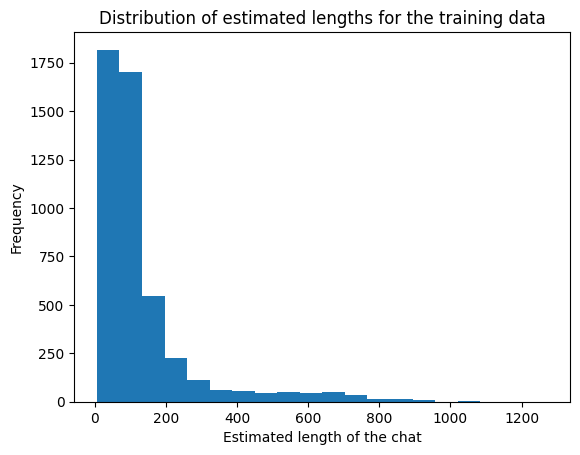

In [ ]:
# Estimation of max_length in train_full_gen_dataset, and the distribution of it

max_length = 0
store_length = []

for data in train_full_gen_dataset:

  length = len(data.split())

  # Update max_length
  if length > max_length:
    max_length = length

  # Store the length estimation
  store_length.append(length)

print("Max length:", max_length)

# Plot distribution of the estimated lengths
plt.hist(store_length, bins=20)
plt.title("Distribution of estimated lengths for the training data")
plt.xlabel("Estimated length of the chat")
plt.ylabel("Frequency")
plt.show()

**=> We will use a max_length of 400 in the tokenizer.**

In [ ]:
# Create the Dataset object
data_dict = {"text": train_full_gen_dataset}
train_gen_dataset = Dataset.from_dict(data_dict)
print(train_gen_dataset[0])

{'text': "<startofstring> If \\(\\vec{k}\\), \\(\\vec{B}_0\\), \\(\\vec{E}_1\\) are all parallel, the solution of the dispersion relation describes Possible answers are: ['The plasma waves', 'The right-handed waves', 'The left-handed waves', 'The ordinary mode']. <bot>: The plasma waves. The family of solutions we are considering is the one corresponding to \\( \\epsilon_3 =0 \\), whose dispersion relation is found to match the plasma waves (in this case, the motion is completely parallel to  \\( \\vec{B}_0 \\)). <endofstring>"}


In [ ]:
# Create the Dataloader object
BATCH_SIZE = 2
train_gen_dataloader = DataLoader(train_gen_dataset, batch_size=BATCH_SIZE, shuffle=True)

**We will use the pretrained model: "cedpsam/chatbot_fr"**
See documentation: https://huggingface.co/cedpsam/chatbot_fr?text=bonjour
The goal will be to fine tune this model with our data.

In [ ]:
# Open the tokenizer and model
# cedpsam/chatbot_fr

## Tokenizer
tokenizer = AutoTokenizer.from_pretrained("cedpsam/chatbot_fr")
tokenizer.add_special_tokens({"pad_token": "<pad>",
                                "bos_token": "<startofstring>",
                                "eos_token": "<endofstring>"})
tokenizer.add_tokens(["<bot>:"])

## Model
model = AutoModelForCausalLM.from_pretrained("cedpsam/chatbot_fr")
model.resize_token_embeddings(len(tokenizer))
model = model.to(DEVICE)

In [ ]:
# Instantiate the optimizer
lr = 1e-3  # learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Training function

def train(model, train_loader, optimizer):
  """
  Main training pipeline.
  """

  # Set the model to training mode
  model.train()

  # Training loop
  for epoch in range(10):

    epoch_loss = 0
    count = 0

    print(f'=== Epoch: {epoch} ===')

    for i, batch in enumerate(tqdm(train_loader, desc='Training '), 0):

      count += BATCH_SIZE

      # Tokenize data
      data = batch['text']
      data_encoded = tokenizer(data, max_length=400, truncation=True, padding="max_length", return_tensors="pt")
      input_ids = data_encoded['input_ids']
      attention_masks = data_encoded['attention_mask']

      # Put to device
      input_ids = input_ids.to(DEVICE)
      attention_masks = attention_masks.to(DEVICE)

      # Forward pass
      outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)

      # Calculate loss
      loss = outputs.loss

      # Clear the gradient buffers of optimizer
      optimizer.zero_grad()

      # Backpropagate loss
      loss.backward()

      # Update optimizer
      optimizer.step()

      # Update statistics
      epoch_loss += loss.item()
      if count%(100*BATCH_SIZE)==0:
        print("loss= {}".format(epoch_loss / count))

    print("loss= {}".format(epoch_loss / count))

In [ ]:
# Training
train(model, train_gen_dataloader, optimizer)

=== Epoch: 0 ===


Training :   4%|▍         | 101/2392 [00:21<06:43,  5.68it/s]

loss= 2.18766194075346


Training :   8%|▊         | 201/2392 [00:38<06:25,  5.68it/s]

loss= 1.9834660038352012


Training :  13%|█▎        | 301/2392 [00:56<06:07,  5.70it/s]

loss= 1.863863033056259


Training :  17%|█▋        | 401/2392 [01:14<05:50,  5.69it/s]

loss= 1.7822744461894036


Training :  21%|██        | 501/2392 [01:31<05:34,  5.65it/s]

loss= 1.7164636430740356


Training :  25%|██▌       | 601/2392 [01:49<05:16,  5.67it/s]

loss= 1.651009740928809


Training :  29%|██▉       | 701/2392 [02:06<04:58,  5.67it/s]

loss= 1.6115053832530974


Training :  33%|███▎      | 801/2392 [02:24<04:40,  5.66it/s]

loss= 1.5638398024439812


Training :  38%|███▊      | 901/2392 [02:42<04:22,  5.69it/s]

loss= 1.532160368329949


Training :  42%|████▏     | 1001/2392 [02:59<04:04,  5.68it/s]

loss= 1.4990883645117283


Training :  46%|████▌     | 1101/2392 [03:17<03:48,  5.65it/s]

loss= 1.4739334007555789


Training :  50%|█████     | 1201/2392 [03:35<03:29,  5.68it/s]

loss= 1.4427903666595618


Training :  54%|█████▍    | 1301/2392 [03:52<03:12,  5.68it/s]

loss= 1.4196418618926636


Training :  59%|█████▊    | 1401/2392 [04:10<02:54,  5.69it/s]

loss= 1.3941257761631694


Training :  63%|██████▎   | 1501/2392 [04:27<02:36,  5.68it/s]

loss= 1.3707446605563163


Training :  67%|██████▋   | 1601/2392 [04:45<02:19,  5.68it/s]

loss= 1.352761642402038


Training :  71%|███████   | 1701/2392 [05:03<02:01,  5.69it/s]

loss= 1.340772434026003


Training :  75%|███████▌  | 1801/2392 [05:20<01:44,  5.66it/s]

loss= 1.3248896726634767


Training :  79%|███████▉  | 1901/2392 [05:38<01:26,  5.68it/s]

loss= 1.3104372738537036


Training :  84%|████████▎ | 2001/2392 [05:55<01:08,  5.68it/s]

loss= 1.297048836313188


Training :  88%|████████▊ | 2101/2392 [06:13<00:51,  5.68it/s]

loss= 1.2818564113406907


Training :  92%|█████████▏| 2201/2392 [06:31<00:33,  5.68it/s]

loss= 1.263727253800766


Training :  96%|█████████▌| 2301/2392 [06:48<00:16,  5.67it/s]

loss= 1.2492060935140952


Training : 100%|██████████| 2392/2392 [07:04<00:00,  5.63it/s]


loss= 1.2369748505866498
=== Epoch: 1 ===


Training :   4%|▍         | 101/2392 [00:17<06:45,  5.65it/s]

loss= 0.8571473090350628


Training :   8%|▊         | 201/2392 [00:35<06:24,  5.69it/s]

loss= 0.8524603369832039


Training :  13%|█▎        | 301/2392 [00:52<06:10,  5.65it/s]

loss= 0.8298068614304066


Training :  17%|█▋        | 401/2392 [01:10<05:50,  5.68it/s]

loss= 0.8367913455516099


Training :  21%|██        | 501/2392 [01:28<05:32,  5.69it/s]

loss= 0.8399250309765339


Training :  25%|██▌       | 601/2392 [01:45<05:15,  5.68it/s]

loss= 0.8423312897483508


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.68it/s]

loss= 0.8442235908338002


Training :  33%|███▎      | 801/2392 [02:21<04:41,  5.65it/s]

loss= 0.843261703401804


Training :  38%|███▊      | 901/2392 [02:38<04:22,  5.68it/s]

loss= 0.8451743521955278


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.67it/s]

loss= 0.8437666907608509


Training :  46%|████▌     | 1101/2392 [03:13<03:47,  5.67it/s]

loss= 0.8389522803507068


Training :  50%|█████     | 1201/2392 [03:31<03:29,  5.68it/s]

loss= 0.8344488403201104


Training :  54%|█████▍    | 1301/2392 [03:49<03:11,  5.69it/s]

loss= 0.8326451107057241


Training :  59%|█████▊    | 1401/2392 [04:06<02:55,  5.66it/s]

loss= 0.8358121791801282


Training :  63%|██████▎   | 1501/2392 [04:24<02:37,  5.67it/s]

loss= 0.8371000168124835


Training :  67%|██████▋   | 1601/2392 [04:42<02:18,  5.70it/s]

loss= 0.8329419368878007


Training :  71%|███████   | 1701/2392 [04:59<02:02,  5.65it/s]

loss= 0.8377687468116775


Training :  75%|███████▌  | 1801/2392 [05:17<01:43,  5.70it/s]

loss= 0.834115885740353


Training :  79%|███████▉  | 1901/2392 [05:34<01:26,  5.69it/s]

loss= 0.8322266704040139


Training :  84%|████████▎ | 2001/2392 [05:52<01:08,  5.68it/s]

loss= 0.8290114066042006


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.68it/s]

loss= 0.8284003227505655


Training :  92%|█████████▏| 2201/2392 [06:27<00:33,  5.65it/s]

loss= 0.8276024537787519


Training :  96%|█████████▌| 2301/2392 [06:45<00:15,  5.70it/s]

loss= 0.8233947764644804


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.68it/s]


loss= 0.8217604175618036
=== Epoch: 2 ===


Training :   4%|▍         | 101/2392 [00:17<06:41,  5.71it/s]

loss= 0.6174395194649697


Training :   8%|▊         | 201/2392 [00:35<06:24,  5.70it/s]

loss= 0.6152601666375994


Training :  13%|█▎        | 301/2392 [00:52<06:07,  5.69it/s]

loss= 0.6289216173936923


Training :  17%|█▋        | 401/2392 [01:10<05:49,  5.70it/s]

loss= 0.6347538056783378


Training :  21%|██        | 501/2392 [01:28<05:32,  5.69it/s]

loss= 0.6359020684659481


Training :  25%|██▌       | 601/2392 [01:45<05:15,  5.67it/s]

loss= 0.6405539227525393


Training :  29%|██▉       | 701/2392 [02:03<04:58,  5.67it/s]

loss= 0.6456202572797026


Training :  33%|███▎      | 801/2392 [02:21<04:39,  5.69it/s]

loss= 0.6575380423106253


Training :  38%|███▊      | 901/2392 [02:38<04:22,  5.69it/s]

loss= 0.6575884782108996


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.66it/s]

loss= 0.6684805317074061


Training :  46%|████▌     | 1101/2392 [03:14<03:47,  5.68it/s]

loss= 0.6710323046960613


Training :  50%|█████     | 1201/2392 [03:31<03:28,  5.70it/s]

loss= 0.673142208866775


Training :  54%|█████▍    | 1301/2392 [03:49<03:11,  5.69it/s]

loss= 0.674166972144292


Training :  59%|█████▊    | 1401/2392 [04:06<02:54,  5.69it/s]

loss= 0.6758458584972791


Training :  63%|██████▎   | 1501/2392 [04:24<02:36,  5.69it/s]

loss= 0.6756182980736096


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.68it/s]

loss= 0.6747922164667398


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.68it/s]

loss= 0.6752177205418839


Training :  75%|███████▌  | 1801/2392 [05:17<01:44,  5.66it/s]

loss= 0.6741201717986001


Training :  79%|███████▉  | 1901/2392 [05:34<01:26,  5.69it/s]

loss= 0.6741248161463361


Training :  84%|████████▎ | 2001/2392 [05:52<01:09,  5.63it/s]

loss= 0.6722804701253772


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.68it/s]

loss= 0.6734591031926019


Training :  92%|█████████▏| 2201/2392 [06:27<00:33,  5.67it/s]

loss= 0.6759865006838333


Training :  96%|█████████▌| 2301/2392 [06:45<00:16,  5.66it/s]

loss= 0.675044936482673


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.68it/s]


loss= 0.6736926203967387
=== Epoch: 3 ===


Training :   4%|▍         | 101/2392 [00:17<06:43,  5.68it/s]

loss= 0.4965485669672489


Training :   8%|▊         | 201/2392 [00:35<06:25,  5.69it/s]

loss= 0.49702268820255996


Training :  13%|█▎        | 301/2392 [00:52<06:10,  5.64it/s]

loss= 0.4986533014227947


Training :  17%|█▋        | 401/2392 [01:10<05:50,  5.68it/s]

loss= 0.5021270104683936


Training :  21%|██        | 501/2392 [01:28<05:32,  5.68it/s]

loss= 0.5051876833587885


Training :  25%|██▌       | 601/2392 [01:45<05:15,  5.67it/s]

loss= 0.5157665396605928


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.68it/s]

loss= 0.5164476971860443


Training :  33%|███▎      | 801/2392 [02:21<04:39,  5.69it/s]

loss= 0.52756916009821


Training :  38%|███▊      | 901/2392 [02:38<04:22,  5.69it/s]

loss= 0.5299291205985679


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.66it/s]

loss= 0.5326788293868303


Training :  46%|████▌     | 1101/2392 [03:14<03:46,  5.69it/s]

loss= 0.5338908416777849


Training :  50%|█████     | 1201/2392 [03:31<03:28,  5.70it/s]

loss= 0.5347655345561604


Training :  54%|█████▍    | 1301/2392 [03:49<03:13,  5.65it/s]

loss= 0.5337705420244199


Training :  59%|█████▊    | 1401/2392 [04:06<02:54,  5.68it/s]

loss= 0.5384645691035049


Training :  63%|██████▎   | 1501/2392 [04:24<02:36,  5.70it/s]

loss= 0.5422628727306922


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.66it/s]

loss= 0.5454748057667166


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.70it/s]

loss= 0.5438931031437482


Training :  75%|███████▌  | 1801/2392 [05:17<01:44,  5.68it/s]

loss= 0.5469479359479414


Training :  79%|███████▉  | 1901/2392 [05:34<01:26,  5.69it/s]

loss= 0.5481881962520512


Training :  84%|████████▎ | 2001/2392 [05:52<01:09,  5.66it/s]

loss= 0.548287600491196


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.69it/s]

loss= 0.5512560123098748


Training :  92%|█████████▏| 2201/2392 [06:27<00:33,  5.69it/s]

loss= 0.5515408356386152


Training :  96%|█████████▌| 2301/2392 [06:45<00:16,  5.68it/s]

loss= 0.5540496118139961


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.68it/s]


loss= 0.5553777329281072
=== Epoch: 4 ===


Training :   4%|▍         | 101/2392 [00:17<06:41,  5.70it/s]

loss= 0.36134276375174523


Training :   8%|▊         | 201/2392 [00:35<06:25,  5.68it/s]

loss= 0.3825515680015087


Training :  13%|█▎        | 301/2392 [00:52<06:08,  5.68it/s]

loss= 0.3905730214466651


Training :  17%|█▋        | 401/2392 [01:10<05:50,  5.68it/s]

loss= 0.3912929284013808


Training :  21%|██        | 501/2392 [01:28<05:32,  5.68it/s]

loss= 0.40319696748256684


Training :  25%|██▌       | 601/2392 [01:45<05:14,  5.69it/s]

loss= 0.41193561488141617


Training :  29%|██▉       | 701/2392 [02:03<04:58,  5.67it/s]

loss= 0.4154781718019928


Training :  33%|███▎      | 801/2392 [02:20<04:38,  5.72it/s]

loss= 0.41520701301284135


Training :  38%|███▊      | 901/2392 [02:38<04:22,  5.67it/s]

loss= 0.41719596792840297


Training :  42%|████▏     | 1001/2392 [02:56<04:03,  5.71it/s]

loss= 0.417498712297529


Training :  46%|████▌     | 1101/2392 [03:13<03:47,  5.67it/s]

loss= 0.4222895021905953


Training :  50%|█████     | 1201/2392 [03:31<03:29,  5.69it/s]

loss= 0.4270881782130649


Training :  54%|█████▍    | 1301/2392 [03:49<03:13,  5.64it/s]

loss= 0.4295344410636104


Training :  59%|█████▊    | 1401/2392 [04:06<02:54,  5.69it/s]

loss= 0.4322898331417569


Training :  63%|██████▎   | 1501/2392 [04:24<02:37,  5.65it/s]

loss= 0.4345659173106154


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.69it/s]

loss= 0.4369389823381789


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.67it/s]

loss= 0.437549192697248


Training :  75%|███████▌  | 1801/2392 [05:17<01:43,  5.69it/s]

loss= 0.43863340964540837


Training :  79%|███████▉  | 1901/2392 [05:34<01:26,  5.69it/s]

loss= 0.4404797971385874


Training :  84%|████████▎ | 2001/2392 [05:52<01:08,  5.67it/s]

loss= 0.44381589016504586


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.68it/s]

loss= 0.4445210148411847


Training :  92%|█████████▏| 2201/2392 [06:27<00:33,  5.65it/s]

loss= 0.4446065651303665


Training :  96%|█████████▌| 2301/2392 [06:45<00:16,  5.67it/s]

loss= 0.44604777879365115


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.68it/s]


loss= 0.44664747596571974
=== Epoch: 5 ===


Training :   4%|▍         | 101/2392 [00:17<06:45,  5.64it/s]

loss= 0.317883093059063


Training :   8%|▊         | 201/2392 [00:35<06:25,  5.68it/s]

loss= 0.2944576102215797


Training :  13%|█▎        | 301/2392 [00:52<06:07,  5.69it/s]

loss= 0.3054542039645215


Training :  17%|█▋        | 401/2392 [01:10<05:49,  5.69it/s]

loss= 0.3147637466201559


Training :  21%|██        | 501/2392 [01:28<05:33,  5.67it/s]

loss= 0.32159149247780444


Training :  25%|██▌       | 601/2392 [01:45<05:14,  5.69it/s]

loss= 0.3203044525751223


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.67it/s]

loss= 0.32131154511389987


Training :  33%|███▎      | 801/2392 [02:21<04:41,  5.66it/s]

loss= 0.32616346749244257


Training :  38%|███▊      | 901/2392 [02:38<04:23,  5.66it/s]

loss= 0.32687829486818776


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.68it/s]

loss= 0.3246950803119689


Training :  46%|████▌     | 1101/2392 [03:14<03:48,  5.65it/s]

loss= 0.3257987550595267


Training :  50%|█████     | 1201/2392 [03:31<03:29,  5.69it/s]

loss= 0.32871283280818414


Training :  54%|█████▍    | 1301/2392 [03:49<03:11,  5.69it/s]

loss= 0.3311267330540487


Training :  59%|█████▊    | 1401/2392 [04:06<02:54,  5.67it/s]

loss= 0.33267025636642106


Training :  63%|██████▎   | 1501/2392 [04:24<02:36,  5.70it/s]

loss= 0.33395066039388377


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.69it/s]

loss= 0.33409653647919185


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.69it/s]

loss= 0.33640319699859794


Training :  75%|███████▌  | 1801/2392 [05:17<01:45,  5.62it/s]

loss= 0.33770018839277327


Training :  79%|███████▉  | 1901/2392 [05:35<01:26,  5.67it/s]

loss= 0.34091950185694975


Training :  84%|████████▎ | 2001/2392 [05:52<01:08,  5.67it/s]

loss= 0.3455110865542665


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.68it/s]

loss= 0.3469248222000897


Training :  92%|█████████▏| 2201/2392 [06:27<00:33,  5.66it/s]

loss= 0.3480008262116462


Training :  96%|█████████▌| 2301/2392 [06:45<00:15,  5.69it/s]

loss= 0.3492897810811258


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.67it/s]


loss= 0.3496168118311298
=== Epoch: 6 ===


Training :   4%|▍         | 101/2392 [00:17<06:44,  5.67it/s]

loss= 0.23076243996620177


Training :   8%|▊         | 201/2392 [00:35<06:25,  5.69it/s]

loss= 0.2315118968114257


Training :  13%|█▎        | 301/2392 [00:53<06:08,  5.68it/s]

loss= 0.23221417925010124


Training :  17%|█▋        | 401/2392 [01:10<05:50,  5.68it/s]

loss= 0.23353247234597801


Training :  21%|██        | 501/2392 [01:28<05:33,  5.68it/s]

loss= 0.23586658603698016


Training :  25%|██▌       | 601/2392 [01:45<05:15,  5.67it/s]

loss= 0.2385180877459546


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.68it/s]

loss= 0.23903619062155484


Training :  33%|███▎      | 800/2392 [02:20<04:40,  5.67it/s]

loss= 0.24185975573956967


Training :  38%|███▊      | 901/2392 [02:38<04:21,  5.71it/s]

loss= 0.2415484146732423


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.67it/s]

loss= 0.24389131152816118


Training :  46%|████▌     | 1101/2392 [03:14<03:47,  5.68it/s]

loss= 0.24619404120370747


Training :  50%|█████     | 1201/2392 [03:31<03:28,  5.70it/s]

loss= 0.24908648024468372


Training :  54%|█████▍    | 1301/2392 [03:49<03:12,  5.68it/s]

loss= 0.2504090328758153


Training :  59%|█████▊    | 1401/2392 [04:07<02:54,  5.67it/s]

loss= 0.2533478518482298


Training :  63%|██████▎   | 1501/2392 [04:24<02:36,  5.68it/s]

loss= 0.25434299003953736


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.67it/s]

loss= 0.25520332463202067


Training :  71%|███████   | 1701/2392 [04:59<02:02,  5.64it/s]

loss= 0.2574817055956844


Training :  75%|███████▌  | 1801/2392 [05:17<01:43,  5.69it/s]

loss= 0.25922693454246554


Training :  79%|███████▉  | 1901/2392 [05:35<01:26,  5.70it/s]

loss= 0.26014557060540505


Training :  84%|████████▎ | 2001/2392 [05:52<01:09,  5.66it/s]

loss= 0.261956035095267


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.68it/s]

loss= 0.2623233880111504


Training :  92%|█████████▏| 2201/2392 [06:28<00:33,  5.69it/s]

loss= 0.2636567779012363


Training :  96%|█████████▌| 2301/2392 [06:45<00:16,  5.65it/s]

loss= 0.2644236457080621


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.67it/s]


loss= 0.26615005090325
=== Epoch: 7 ===


Training :   4%|▍         | 101/2392 [00:17<06:43,  5.68it/s]

loss= 0.1740279329009354


Training :   8%|▊         | 201/2392 [00:35<06:26,  5.67it/s]

loss= 0.17582676724530757


Training :  13%|█▎        | 301/2392 [00:53<06:09,  5.66it/s]

loss= 0.173851547340552


Training :  17%|█▋        | 401/2392 [01:10<05:49,  5.70it/s]

loss= 0.1745546280685812


Training :  21%|██        | 501/2392 [01:28<05:34,  5.66it/s]

loss= 0.18008238708227872


Training :  25%|██▌       | 601/2392 [01:45<05:18,  5.62it/s]

loss= 0.18123020473867654


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.68it/s]

loss= 0.18113379604582275


Training :  33%|███▎      | 801/2392 [02:21<04:40,  5.67it/s]

loss= 0.18283280370291322


Training :  38%|███▊      | 901/2392 [02:38<04:22,  5.69it/s]

loss= 0.1852488216592206


Training :  42%|████▏     | 1001/2392 [02:56<04:06,  5.63it/s]

loss= 0.18684193405881525


Training :  46%|████▌     | 1101/2392 [03:14<03:47,  5.68it/s]

loss= 0.18921872134235773


Training :  50%|█████     | 1201/2392 [03:31<03:29,  5.68it/s]

loss= 0.19133112476517758


Training :  54%|█████▍    | 1301/2392 [03:49<03:12,  5.65it/s]

loss= 0.1912444533407688


Training :  59%|█████▊    | 1401/2392 [04:07<02:54,  5.68it/s]

loss= 0.192340154941859


Training :  63%|██████▎   | 1501/2392 [04:24<02:37,  5.66it/s]

loss= 0.19374529106294117


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.67it/s]

loss= 0.1948902889864985


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.66it/s]

loss= 0.19851406928699683


Training :  75%|███████▌  | 1801/2392 [05:17<01:43,  5.68it/s]

loss= 0.20045540288401148


Training :  79%|███████▉  | 1901/2392 [05:35<01:26,  5.67it/s]

loss= 0.20107629906288102


Training :  84%|████████▎ | 2001/2392 [05:52<01:08,  5.67it/s]

loss= 0.2020743812220171


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.71it/s]

loss= 0.20299247383805258


Training :  92%|█████████▏| 2201/2392 [06:28<00:33,  5.66it/s]

loss= 0.20480062361129306


Training :  96%|█████████▌| 2301/2392 [06:45<00:16,  5.67it/s]

loss= 0.20560174818434146


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.67it/s]


loss= 0.2069512427687944
=== Epoch: 8 ===


Training :   4%|▍         | 101/2392 [00:17<06:41,  5.70it/s]

loss= 0.14339761696755887


Training :   8%|▊         | 201/2392 [00:35<06:26,  5.67it/s]

loss= 0.14330285091884434


Training :  13%|█▎        | 301/2392 [00:53<06:09,  5.65it/s]

loss= 0.1424524539212386


Training :  17%|█▋        | 401/2392 [01:10<05:49,  5.69it/s]

loss= 0.14307816195301712


Training :  21%|██        | 501/2392 [01:28<05:32,  5.69it/s]

loss= 0.14177137818187474


Training :  25%|██▌       | 601/2392 [01:45<05:16,  5.65it/s]

loss= 0.14252708822799226


Training :  29%|██▉       | 701/2392 [02:03<04:57,  5.68it/s]

loss= 0.14275920629767436


Training :  33%|███▎      | 801/2392 [02:21<04:41,  5.66it/s]

loss= 0.14455578793073073


Training :  38%|███▊      | 901/2392 [02:38<04:23,  5.66it/s]

loss= 0.14528232768384947


Training :  42%|████▏     | 1001/2392 [02:56<04:04,  5.70it/s]

loss= 0.14632225275598468


Training :  46%|████▌     | 1101/2392 [03:14<03:47,  5.67it/s]

loss= 0.1475052134472538


Training :  50%|█████     | 1201/2392 [03:31<03:30,  5.66it/s]

loss= 0.14868215790484102


Training :  54%|█████▍    | 1301/2392 [03:49<03:11,  5.69it/s]

loss= 0.15031587877669014


Training :  59%|█████▊    | 1401/2392 [04:07<02:55,  5.66it/s]

loss= 0.15216081644408405


Training :  63%|██████▎   | 1501/2392 [04:24<02:37,  5.67it/s]

loss= 0.15354860247050722


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.66it/s]

loss= 0.15503266294137574


Training :  71%|███████   | 1701/2392 [04:59<02:01,  5.68it/s]

loss= 0.1569629230711828


Training :  75%|███████▌  | 1801/2392 [05:17<01:44,  5.67it/s]

loss= 0.15848286655524538


Training :  79%|███████▉  | 1901/2392 [05:35<01:26,  5.65it/s]

loss= 0.15906458003838594


Training :  84%|████████▎ | 2001/2392 [05:52<01:08,  5.68it/s]

loss= 0.16130341486353428


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.67it/s]

loss= 0.16290689807473904


Training :  92%|█████████▏| 2201/2392 [06:28<00:33,  5.68it/s]

loss= 0.1648094485200603


Training :  96%|█████████▌| 2301/2392 [06:45<00:15,  5.69it/s]

loss= 0.16574592351832468


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.67it/s]


loss= 0.16691896751177276
=== Epoch: 9 ===


Training :   4%|▍         | 101/2392 [00:17<06:44,  5.66it/s]

loss= 0.11618222137913108


Training :   8%|▊         | 201/2392 [00:35<06:27,  5.66it/s]

loss= 0.11439431190490723


Training :  13%|█▎        | 301/2392 [00:53<06:08,  5.67it/s]

loss= 0.11639040653283397


Training :  17%|█▋        | 401/2392 [01:10<05:50,  5.69it/s]

loss= 0.11339203813811764


Training :  21%|██        | 501/2392 [01:28<05:33,  5.67it/s]

loss= 0.11629699925146997


Training :  25%|██▌       | 601/2392 [01:45<05:15,  5.68it/s]

loss= 0.11777869038749486


Training :  29%|██▉       | 701/2392 [02:03<04:59,  5.65it/s]

loss= 0.1200058690870979


Training :  33%|███▎      | 801/2392 [02:21<04:40,  5.68it/s]

loss= 0.1213030087214429


Training :  38%|███▊      | 901/2392 [02:39<04:22,  5.67it/s]

loss= 0.12288648312807911


Training :  42%|████▏     | 1001/2392 [02:56<04:05,  5.66it/s]

loss= 0.12426352207828313


Training :  46%|████▌     | 1101/2392 [03:14<03:48,  5.66it/s]

loss= 0.1257897885829549


Training :  50%|█████     | 1201/2392 [03:31<03:30,  5.66it/s]

loss= 0.12620842579674596


Training :  54%|█████▍    | 1301/2392 [03:49<03:11,  5.69it/s]

loss= 0.1268321421950196


Training :  59%|█████▊    | 1401/2392 [04:07<02:54,  5.68it/s]

loss= 0.12873185186447308


Training :  63%|██████▎   | 1501/2392 [04:24<02:37,  5.64it/s]

loss= 0.13026389977894723


Training :  67%|██████▋   | 1601/2392 [04:42<02:19,  5.68it/s]

loss= 0.1317273642186774


Training :  71%|███████   | 1701/2392 [05:00<02:01,  5.69it/s]

loss= 0.13257998227141798


Training :  75%|███████▌  | 1801/2392 [05:17<01:44,  5.63it/s]

loss= 0.1338293962030568


Training :  79%|███████▉  | 1901/2392 [05:35<01:26,  5.66it/s]

loss= 0.13446097918393973


Training :  84%|████████▎ | 2001/2392 [05:52<01:09,  5.65it/s]

loss= 0.13534701558714732


Training :  88%|████████▊ | 2101/2392 [06:10<00:51,  5.65it/s]

loss= 0.1361271637247964


Training :  92%|█████████▏| 2201/2392 [06:28<00:33,  5.67it/s]

loss= 0.13730042450256985


Training :  96%|█████████▌| 2301/2392 [06:45<00:15,  5.69it/s]

loss= 0.1377877476564406


Training : 100%|██████████| 2392/2392 [07:01<00:00,  5.67it/s]

loss= 0.13866647342212163


In [ ]:
# Save model
tokenizer.save_pretrained(ROOT_PATH+"/final_model")
model.save_pretrained(ROOT_PATH+"/final_model")

## 4. Evaluate the Final model

In [ ]:
# Open final model and its tokenizer
tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH+"/final_model")
model = AutoModelForCausalLM.from_pretrained(ROOT_PATH+"/final_model")

# Set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [ ]:
# Open testing data
with open(ROOT_PATH+'/data/test_full_gen_dataset_teamRFL.json', encoding="utf8") as json_file:
    test_full_gen_dataset = json.load(json_file)

In [ ]:
# Checking
test_full_gen_dataset[0:2]

["<startofstring> Assume you are working on a mobile application. Users complain that your app's image gallery uses too much of their mobile data.\nIn one sentence, explain the first step towards improving this: <bot>: The app could stream images rather than batch them, to only download images the user actually sees. <endofstring>",
 "<startofstring> The \\textbf{hyperparameters} are learned with ...\n(One answer) Possible answers are: [' training ', '  validation ', ' test ', ' all the data together ']. <bot>: ['  validation ']. <endofstring>"]

In [ ]:
# Create the Dataset object
data_dict = {"text": test_full_gen_dataset}
test_gen_dataset = Dataset.from_dict(data_dict)
print(test_gen_dataset[0])

{'text': "<startofstring> Assume you are working on a mobile application. Users complain that your app's image gallery uses too much of their mobile data.\nIn one sentence, explain the first step towards improving this: <bot>: The app could stream images rather than batch them, to only download images the user actually sees. <endofstring>"}


In [ ]:
# Create the Dataloader object
BATCH_SIZE = 2
test_gen_dataloader = DataLoader(test_gen_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Open reward_model

AutoConfig.register('CustomRewardModel', CustomRewardModelConfig)
AutoModel.register(CustomRewardModelConfig, CustomRewardModel)

reward_config = AutoConfig.from_pretrained(ROOT_PATH+"/reward_model")
reward_model = AutoModel.from_pretrained(ROOT_PATH+"/reward_model", config=reward_config)
reward_model = reward_model.to(DEVICE)

In [ ]:
# Load BERT evaluation
bertscore = load("bertscore")

### 4.1. Evaluation without split at bot

In [ ]:
# Evaluate function WITHOUT SPLIT AT <BOT>

def evaluation_without_split(model, test_loader):
  """
  Main testing pipeline.
  """

  # Set the model to testing mode
  model.eval()

  total_loss = 0
  count = 0
  store_chats = []
  store_reward_scores = []
  store_BERTscores = {'precision': [], 'recall': [], 'f1': []}

  for batch in tqdm(test_loader):
    with torch.no_grad():

      count += BATCH_SIZE

      # Tokenize data
      data = batch['text']
      data_encoded = tokenizer(data, max_length=400, truncation=True, padding="max_length", return_tensors="pt")
      input_ids = data_encoded['input_ids']
      attention_masks = data_encoded['attention_mask']

      # Put to device
      input_ids = input_ids.to(DEVICE)
      attention_masks = attention_masks.to(DEVICE)

      # Forward pass
      outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)

      # Decode outputs
      predicted_tokens = torch.argmax(outputs.logits, dim=-1)
      outputs_decoded = []
      for i in range(predicted_tokens.shape[0]):
        output_tokens = predicted_tokens[i].tolist()
        decoded_text = tokenizer.decode(output_tokens, skip_special_tokens=True)
        outputs_decoded.append(decoded_text)

      # Calculate and store loss
      loss = outputs.loss
      total_loss += loss.item()

      # Store chats
      for i in range(len(batch['text'])):
        store_chats.append((batch['text'][i], outputs_decoded[i]))

      # Apply reward model and store scores
      inputs_to_get_scores = []
      for i in range(len(batch['text'])):
        string = outputs_decoded[i]
        string = string.replace("<startofstring> ", "Human: ")
        string = string.replace(" <bot>: ", "\n\nAssistant: ")
        string = string.replace(" <endofstring>", "")
        inputs_to_get_scores.append(string)
      scores = reward_model.get_score(inputs_to_get_scores)
      for i in range(len(scores)):
        store_reward_scores.append(scores[i].detach().item())

      # Store BERT scores
      predictions = []
      references = []
      for i in range(len(outputs_decoded)):
        predictions.append(outputs_decoded[i])
        references.append(batch['text'][i])
      new_BERT_scores = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
      for key in store_BERTscores:
        store_BERTscores[key].extend(new_BERT_scores[key])

  return total_loss/count, store_chats, store_reward_scores, store_BERTscores

In [ ]:
# Evaluation
eval_loss_without_split, store_chats_without_split, store_reward_scores_without_split, store_BERTscores_without_split = evaluation_without_split(model, test_gen_dataloader)

  0%|          | 0/267 [00:00<?, ?it/s]

100%|██████████| 267/267 [00:38<00:00,  6.97it/s]


In [ ]:
# Store evaluation results

with open(ROOT_PATH+"/data/evaluation_final_model_store_chats_without_split", "wb") as fp:   #Pickling
  pickle.dump(store_chats_without_split, fp)

with open(ROOT_PATH+"/data/evaluation_final_model_store_reward_scores_without_split", "wb") as fp:   #Pickling
  pickle.dump(store_reward_scores_without_split, fp)

with open(ROOT_PATH+'/data/evaluation_final_model_store_BERTscores_without_split.json', 'w') as f:
    json.dump(store_BERTscores_without_split, f, indent=4)

In [ ]:
# Look at the loss
print("Evaluation loss= {}".format(eval_loss_without_split))

Evaluation loss= 0.9751101530641876


In [ ]:
# Look at some chat
for i in [4, 5, 7]:
  print("####################### Chat {} #######################".format(i))
  print("")
  print("--------- Input ---------")
  print(store_chats_without_split[i][0])
  print("")
  print("--------- Ouput ---------")
  print(store_chats_without_split[i][1])
  print("")

####################### Chat 4 #######################

--------- Input ---------
<startofstring> In the context of superscalar processors, what is the function of a Load Store Queue (LSQ)? <bot>:  The LSQ decides which and when memory accesses can be executed out of the original program order.. <endofstring>

--------- Ouput ---------
 What the folt of Loerg, eff,,, the is the purction of the fad Store Queue?V or) and <bot>:  For anat(Q forf of cons funen theasureory ines the be eecuted andp the  l.er. 

####################### Chat 5 #######################

--------- Input ---------
<startofstring> Report the mean and standard deviation of IPSP amplitudes as well as the conductance scaling factor from SP_PVBC-SP_PC.summary.yaml. What is the conductance scaling factor in (pathway).summary.yaml <bot>: 1+0.1. <endofstring>

--------- Ouput ---------
 Whattra correctchan and the deviates of theBP genouleph and aell as which mctance ofing ofor. a andPro�/ Pos/:AA What Pos 0  stph  is the

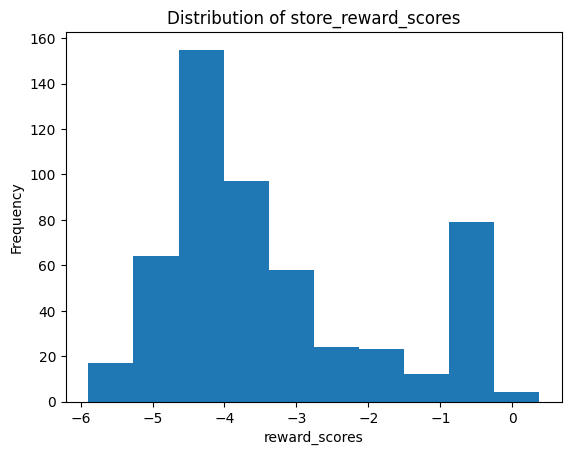

In [ ]:
# Look at the distribution of the reward_scores
plt.hist(store_reward_scores_without_split)
plt.title("Distribution of store_reward_scores")
plt.xlabel("reward_scores")
plt.ylabel("Frequency")
plt.show()

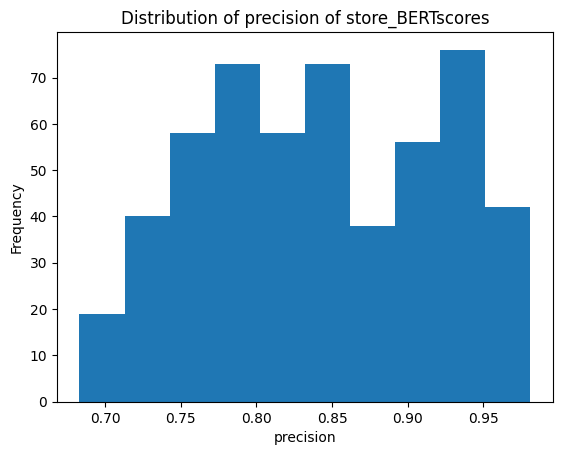

In [ ]:
# Look at the distribution of the precision of BERTscores
plt.hist(store_BERTscores_without_split['precision'])
plt.title("Distribution of precision of store_BERTscores")
plt.xlabel("precision")
plt.ylabel("Frequency")
plt.show()

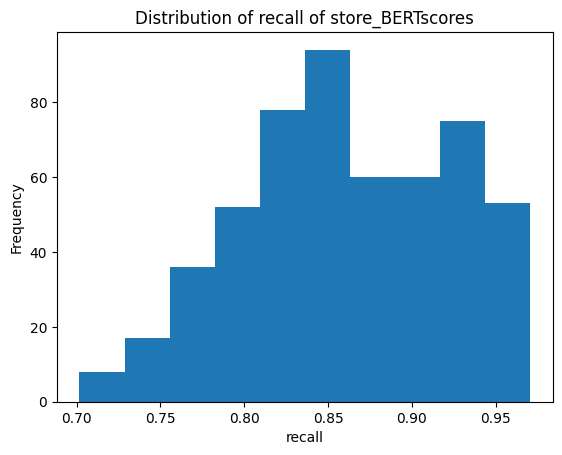

In [ ]:
# Look at the distribution of the recall of BERTscores
plt.hist(store_BERTscores_without_split['recall'])
plt.title("Distribution of recall of store_BERTscores")
plt.xlabel("recall")
plt.ylabel("Frequency")
plt.show()

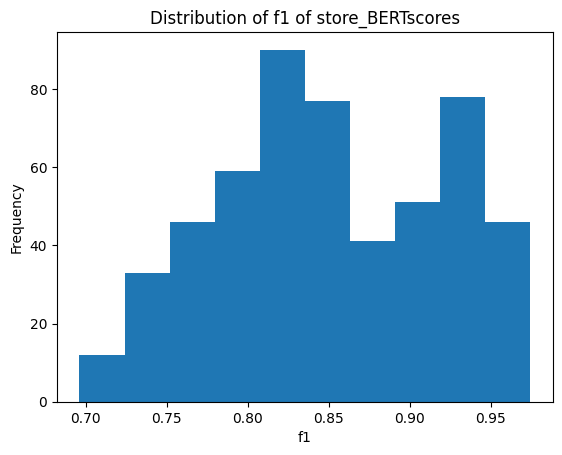

In [ ]:
# Look at the distribution of the f1 score of BERTscores
plt.hist(store_BERTscores_without_split['f1'])
plt.title("Distribution of f1 of store_BERTscores")
plt.xlabel("f1")
plt.ylabel("Frequency")
plt.show()

### 4.2. Evaluation with split at bot

In [ ]:
# Evaluate function WITH SPLIT AT <BOT>

def evaluation_with_split(model, test_loader):
  """
  Main testing pipeline.
  """

  # Set the model to testing mode
  model.eval()

  total_loss = 0
  count = 0
  store_chats = []
  store_reward_scores = []
  store_BERTscores = {'precision': [], 'recall': [], 'f1': []}

  for batch in tqdm(test_loader):
    with torch.no_grad():

      count += BATCH_SIZE

      # Tokenize data
      data = batch['text']
      data_encoded = tokenizer(data, max_length=400, truncation=True, padding="max_length", return_tensors="pt")
      input_ids = data_encoded['input_ids']
      attention_masks = data_encoded['attention_mask']

      # Put to device
      input_ids = input_ids.to(DEVICE)
      attention_masks = attention_masks.to(DEVICE)

      # Forward pass
      outputs = model(input_ids, attention_mask=attention_masks, labels=input_ids)

      # Decode outputs
      predicted_tokens = torch.argmax(outputs.logits, dim=-1)
      outputs_decoded = []
      for i in range(predicted_tokens.shape[0]):
        output_tokens = predicted_tokens[i].tolist()
        decoded_text = tokenizer.decode(output_tokens, skip_special_tokens=True)
        if "<bot>:" in decoded_text:
            answer_text = decoded_text.split("<bot>:")[1].strip()
        else:
            answer_text = ""
        outputs_decoded.append(answer_text)

      # Calculate and store loss
      loss = outputs.loss
      total_loss += loss.item()

      # Store chats
      for i in range(len(batch['text'])):
        store_chats.append((batch['text'][i], outputs_decoded[i]))

      # Apply reward model and store scores
      inputs_to_get_scores = []
      for i in range(len(batch['text'])):
        string = batch['text'][i].split("<bot>:")[0].strip()
        string += "<bot>: "
        string += outputs_decoded[i]
        string = string.replace("<startofstring> ", "Human: ")
        string = string.replace(" <bot>: ", "\n\nAssistant: ")
        string = string.replace(" <endofstring>", "")
        inputs_to_get_scores.append(string)
      scores = reward_model.get_score(inputs_to_get_scores)
      for i in range(len(scores)):
        store_reward_scores.append(scores[i].detach().item())

      # Store BERT scores
      predictions = []
      references = []
      for i in range(len(outputs_decoded)):
        predictions.append(outputs_decoded[i])
        references.append(batch['text'][i].split("<bot>:")[1].strip())
      new_BERT_scores = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
      for key in store_BERTscores:
        store_BERTscores[key].extend(new_BERT_scores[key])

  return total_loss/count, store_chats, store_reward_scores, store_BERTscores

In [ ]:
# Evaluation
eval_loss_with_split, store_chats_with_split, store_reward_scores_with_split, store_BERTscores_with_split = evaluation_with_split(model, test_gen_dataloader)

100%|██████████| 267/267 [00:36<00:00,  7.39it/s]


In [ ]:
# Store evaluation results

with open(ROOT_PATH+"/data/evaluation_final_model_store_chats_with_split", "wb") as fp:   #Pickling
  pickle.dump(store_chats_with_split, fp)

with open(ROOT_PATH+"/data/evaluation_final_model_store_reward_scores_with_split", "wb") as fp:   #Pickling
  pickle.dump(store_reward_scores_with_split, fp)

with open(ROOT_PATH+'/data/evaluation_final_model_store_BERTscores_with_split.json', 'w') as f:
    json.dump(store_BERTscores_with_split, f, indent=4)

In [ ]:
# Look at the loss
print("Evaluation loss= {}".format(eval_loss_with_split))

Evaluation loss= 0.9705664272584049


In [ ]:
# Look at some chat
for i in [4, 5, 7]:
  print("####################### Chat {} #######################".format(i))
  print("")
  print("--------- Input ---------")
  print(store_chats_with_split[i][0])
  print("")
  print("--------- Ouput ---------")
  print(store_chats_with_split[i][1])
  print("")

####################### Chat 4 #######################

--------- Input ---------
<startofstring> Which of the following involves emission of a signal from a patient? Possible answers are: ['CT', 'Diagnostic ultrasound', 'Projection radiography', 'Radioisotope imaging', 'Spiral CT']. <bot>: Radioisotope imaging. Source: http://opax.swin.edu.au/~dliley/lectures/het408/radio.pdf <endofstring>

--------- Ouput ---------
Radioisotope imaging. Source: http://opax.swin.edu.au/~dlike/lectures/het408/radio.pdf

####################### Chat 5 #######################

--------- Input ---------
<startofstring> What makes dMRI different from both RSFC and MACM? Possible answers are: ['dMRI focuses on white matter, whereas RSFC and MACM focus on grey matter', 'dMRI is a structural approach, whereas RSFC and MACM are functional approaches', 'dMRI focuses on the resting brain, whereas RSFC and MACM are task-dependent', 'dMRI focuses on grey matter, whereas RSFC and MACM focus on white matter']. <bot>

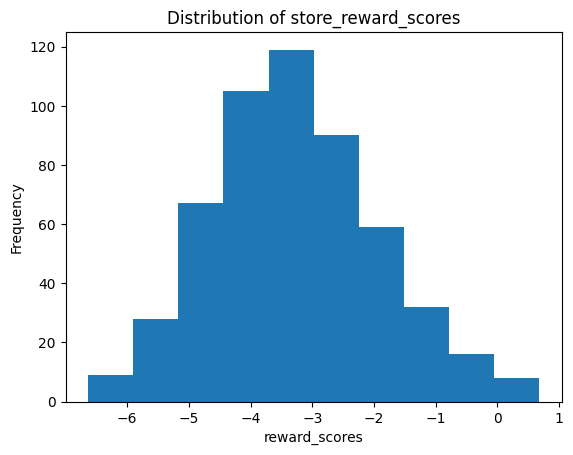

In [ ]:
# Look at the distribution of the reward_scores
plt.hist(store_reward_scores_with_split)
plt.title("Distribution of store_reward_scores")
plt.xlabel("reward_scores")
plt.ylabel("Frequency")
plt.show()

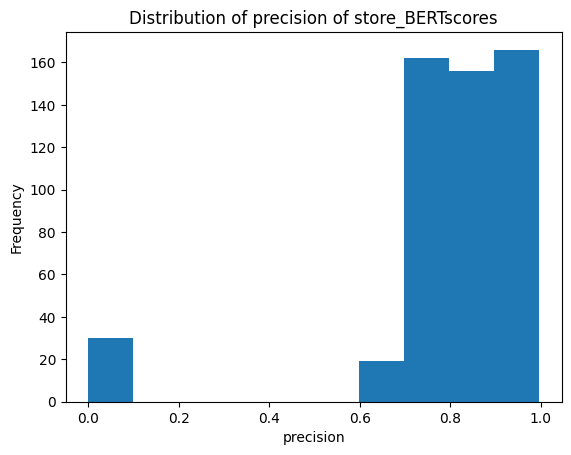

In [ ]:
# Look at the distribution of the precision of BERTscores
plt.hist(store_BERTscores_with_split['precision'])
plt.title("Distribution of precision of store_BERTscores")
plt.xlabel("precision")
plt.ylabel("Frequency")
plt.show()

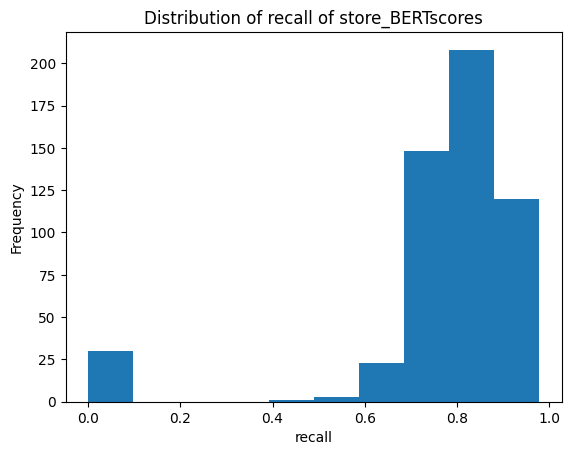

In [ ]:
# Look at the distribution of the recall of BERTscores
plt.hist(store_BERTscores_with_split['recall'])
plt.title("Distribution of recall of store_BERTscores")
plt.xlabel("recall")
plt.ylabel("Frequency")
plt.show()

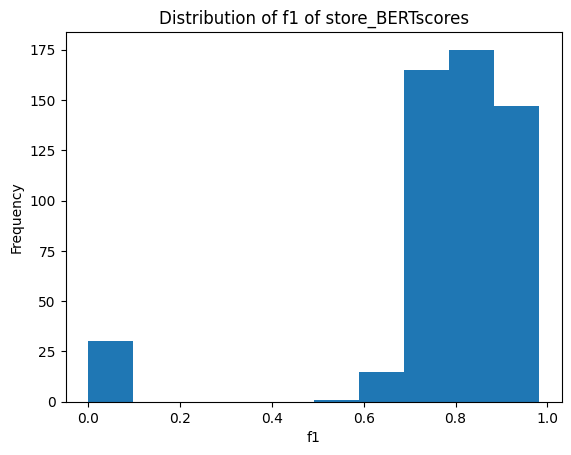

In [ ]:
# Look at the distribution of the f1 score of BERTscores
plt.hist(store_BERTscores_with_split['f1'])
plt.title("Distribution of f1 of store_BERTscores")
plt.xlabel("f1")
plt.ylabel("Frequency")
plt.show()

### 4.3. Evaluation with generate

In [ ]:
# Evaluate function with GENERATE

def evaluation_with_generate(model, test_dataset):
  """
  Main testing pipeline.
  """

  # Set the model to testing mode
  model.eval()

  total_loss = 0
  count = 0
  store_chats = []
  store_reward_scores = []
  store_BERTscores = {'precision': [], 'recall': [], 'f1': []}

  for entry in tqdm(test_dataset):
    with torch.no_grad():

      count += 1

      # Tokenize data
      data = entry['text']
      prompt = entry['text'].split("<bot>: ")[0].strip()
      prompt += " <bot>: "
      data_encoded = tokenizer(prompt, max_length=400, truncation=True, padding="max_length", return_tensors="pt")
      input_ids = data_encoded['input_ids']
      attention_masks = data_encoded['attention_mask']

      # Put to device
      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_masks.to(DEVICE)

      # Forward pass
      output = model.generate(input_ids, attention_mask=attention_mask, max_length=1000, pad_token_id=tokenizer.eos_token_id, top_p=0.92, top_k=50)

      # Decode outputs
      output_decoded = tokenizer.decode(output[0], skip_special_tokens=True)

      # Store chats
      store_chats.append((entry['text'], output_decoded))

      # Apply reward model and store scores
      string = entry['text'].split("<bot>: ")[0].strip()
      string += "<bot>: "
      string += output_decoded
      string = string.replace("<startofstring> ", "Human: ")
      string = string.replace(" <bot>: ", "\n\nAssistant: ")
      string = string.replace(" <endofstring>", "")
      scores = reward_model.get_score([string])
      for i in range(len(scores)):
        store_reward_scores.append(scores[i].detach().item())

      # Store BERT scores
      predictions= [output_decoded]
      references = [entry['text'].split("<bot>: ")[1].strip()]
      new_BERT_scores = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
      for key in store_BERTscores:
        store_BERTscores[key].extend(new_BERT_scores[key])

  return store_chats, store_reward_scores, store_BERTscores

In [ ]:
# Evaluation
store_chats_with_generate, store_reward_scores_with_generate, store_BERTscores_with_generate = evaluation_with_generate(model, test_gen_dataset)

100%|██████████| 533/533 [2:16:44<00:00, 15.39s/it]


In [ ]:
# Store evaluation results

with open(ROOT_PATH+"/data/evaluation_final_model_store_chats_with_generate", "wb") as fp:   #Pickling
  pickle.dump(store_chats_with_generate, fp)

with open(ROOT_PATH+"/data/evaluation_final_model_store_reward_scores_with_generate", "wb") as fp:   #Pickling
  pickle.dump(store_reward_scores_with_generate, fp)

with open(ROOT_PATH+'/data/evaluation_final_model_store_BERTscores_with_generate.json', 'w') as f:
    json.dump(store_BERTscores_with_generate, f, indent=4)

In [ ]:
# Look at some chat
for i in [4, 5, 7]:
  print("####################### Chat {} #######################".format(i))
  print("")
  print("--------- Input ---------")
  print(store_chats_with_generate[i][0])
  print("")
  print("--------- Ouput ---------")
  print(store_chats_with_generate[i][1])
  print("")

####################### Chat 4 #######################

--------- Input ---------
<startofstring> (Minima) Convex functions over a convex set have a unique global minimum. Possible answers are: ['True', 'False']. <bot>: False. False. Strictly convex functions have a unique global minimum, but this is not the case for convex functions in general. <endofstring>

--------- Ouput ---------
 (Minima) Convex functions over a convex set have a unique global minimum. Possible answers are: ['True', 'False']. <bot>: ographymatrixtake, where the non-intersecting closed intervals and the non-intersecting closed intervals are the same basic non-intersecting closed intervals. ween the concerne and the non-intersecting closed intervals. 

####################### Chat 5 #######################

--------- Input ---------
<startofstring> Which of the following statements is true? Possible answers are: ['Is due to photoelectric absorption and Compton scatter.', 'Gives the relative number of x-rays emitte

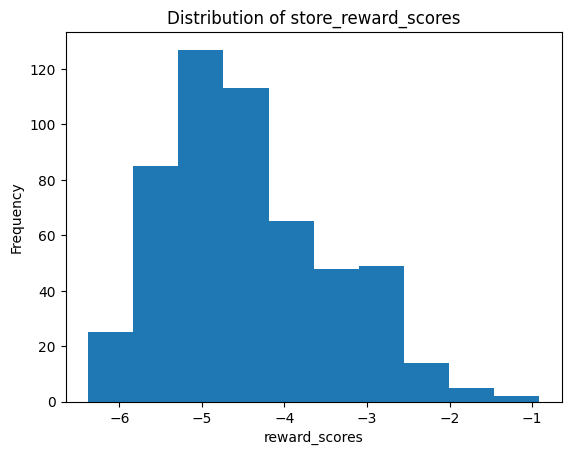

In [ ]:
# Look at the distribution of the reward_scores
plt.hist(store_reward_scores_with_generate)
plt.title("Distribution of store_reward_scores")
plt.xlabel("reward_scores")
plt.ylabel("Frequency")
plt.show()

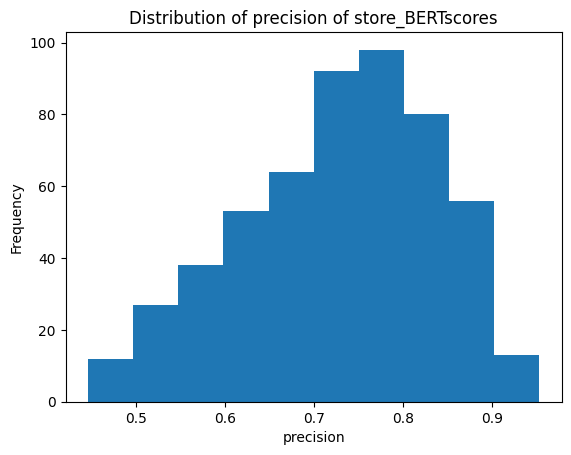

In [ ]:
# Look at the distribution of the precision of BERTscores
plt.hist(store_BERTscores_with_generate['precision'])
plt.title("Distribution of precision of store_BERTscores")
plt.xlabel("precision")
plt.ylabel("Frequency")
plt.show()

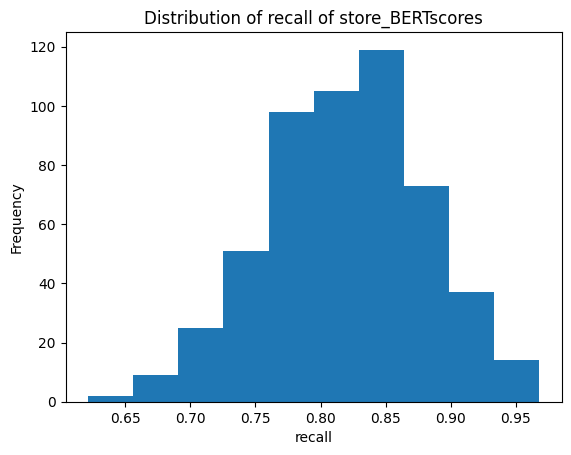

In [ ]:
# Look at the distribution of the recall of BERTscores
plt.hist(store_BERTscores_with_generate['recall'])
plt.title("Distribution of recall of store_BERTscores")
plt.xlabel("recall")
plt.ylabel("Frequency")
plt.show()

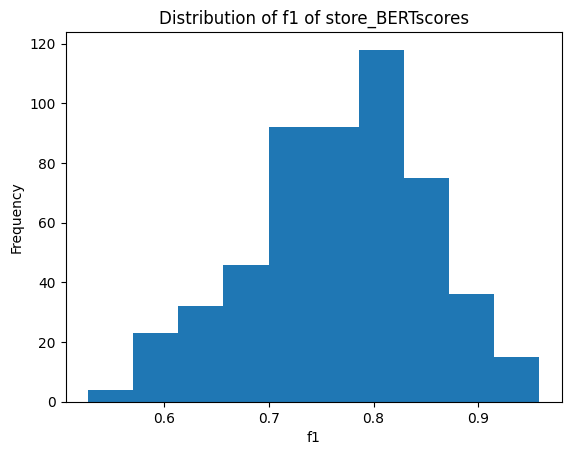

In [ ]:
# Look at the distribution of the f1 score of BERTscores
plt.hist(store_BERTscores_with_generate['f1'])
plt.title("Distribution of f1 of store_BERTscores")
plt.xlabel("f1")
plt.ylabel("Frequency")
plt.show()

## 6. Inference

In [6]:
# Open final model and its tokenizer
tokenizer = AutoTokenizer.from_pretrained(ROOT_PATH+"/final_model")
model = AutoModelForCausalLM.from_pretrained(ROOT_PATH+"/final_model")

# Set device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [7]:
# Open prompt data
with open(ROOT_PATH+'/data/prompts.json', encoding="utf8") as json_file:
    prompts_data = json.load(json_file)

prompts_data[0:3]

[{'guid': '94cdfd24-de94-4072-a5aa-a3a9dc953d2b',
  'question': "Soit \\(f\\) une fonction paire (resp. impaire) \npossédant un \\(DL(n)\\) autour de \\(x_0=0\\):\n\\[ \nf(x)=a_0+a_1x+a_2x^2+\\cdots+a_nx^n+x^n\\epsilon(x)\\,.\n\\]\nMontrer que tous les coefficients d'indices \nimpairs (resp. pairs) sont nuls.",
  'answer': "Soit \\(f\\) une fonction paire, possédant\nun développement limité d'ordre impair \\(2n+1\\).\nEn soustrayant les expressions\n\\begin{align*} \nf(x)&=a_0+a_1x+a_2x^2+\\cdots+a_{2n+1}x^{2n+1}+x^{2n+1}\\epsilon(x)\\\\\nf(-x)&=a_0-a_1x+a_2x^2+\\cdots-a_{2n+1}x^{2n+1}-x^{2n+1}\\epsilon(-x)\\,,\n\\end{align*}\non obtient\n\\[ \n0=2a_1x+2a_3x^3+\\cdots +2a_{2n+1}x^{2n+1}+x^{2n+1}\n\\underbrace{2(\\epsilon(x)+\\epsilon(-x))}_{=\\phi(x)}\\,.\n\\]\nComme \\(\\phi(x)\\to 0\\) lorsque \\(x\\to 0\\), il faut interpréter cette expression\ncomme le développement limité de la fonction nulle (le ``\\(0\\)'' de gauche)\nautour de zéro. Mais la partie principale de ce développement

In [8]:
# Inference function

def infer(prompt):

  with torch.no_grad():

    prompt = "<startofstring> " + prompt + " <bot>: "
    prompt = tokenizer(prompt, return_tensors="pt")

    input_ids = prompt["input_ids"].to(DEVICE)
    attention_mask = prompt["attention_mask"].to(DEVICE)

    output = model.generate(input_ids, attention_mask=attention_mask, max_length=1000, pad_token_id=tokenizer.eos_token_id, top_p=0.92, top_k=50)
    output = tokenizer.decode(output[0], skip_special_tokens=True)

    return output

In [20]:
# Answer to the prompts_data

answers = []

for entry in tqdm(prompts_data):

  guid = entry['guid']
  question = entry['question']
  choices = entry.get('choices', [])

  prompt = question
  if choices:
    prompt += f" Possible answers are: {choices}."

  model_answer = infer(question)
  bot = model_answer.split("<bot>: ")[1].strip()

  answers.append({'guid': guid, 'model_answer': bot})

In [20]:
# Save answers in data folder
with open(ROOT_PATH+'/data/answers_teamRFL.json', 'w') as f:
    json.dump(answers, f, indent=4)

In [22]:
# Checking
answers[10:12]

[{'guid': 'b82db1db-a6f9-4e3a-8d45-9a89cfddd953',
  'model_answer': 'def gradient_rank(x) = \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x) + \\textbf{(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x) + \\textbf{(x)^2_rank(x) + \\textbf{(x) + \\textbf{(x) + \\textbf{(x) - \\textbf{(x)^2_rank(x) + \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x)^2_rank(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x)^2_rankappa_rankappa_rankappa_rankappa_rankappa_rank(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\textbf{(x) - \\t

In [23]:
# Checking
len(answers)

100